In [2]:
%load_ext autoreload
%autoreload 2
import ast
from build import item
from build import build
from build.config import dmg
import utils.skillpoints as sp
from utils import dmgcalc
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [5]:
def get_data(weapon, file):
    with open(file, 'r') as f:
        lines = f.readlines()
    score = []
    real = []
    builds = []
    reqsps = []
    bonsps = []
    freesp = []
    
    for i, text in enumerate(lines):
        data = ast.literal_eval(text)
        real.append(data[1])
        score.append(data[2])
    
        items = [item.get_item(n) for n in data[0]]
        b = build.Build(weapon, *items)
        reqsp, bonsp = b.calc_sp()
        reqsps.append(reqsp)
        bonsps.append(bonsp)
        freesp.append(204-sum(reqsp))
    
        builditem = sp.add_sp(b.build(), *b.calc_sp())
        for t,m in zip(dmgcalc.damageTypes, dmg.mastery):
            builditem.identifications[t] += 15*m
        builds.append(builditem)
    return (score, real, builds, reqsps, bonsps, freesp)
    
def plot2D(x, y, r=None, bins=None, xlabel='x', ylabel='y'):
    if r is None:
        r = [[min(x),max(x)],[min(y),max(y)]]
    if bins is None:
        bins=(100,100)
    plt.hist2d(x, y, bins=bins, cmap='jet', norm=colors.LogNorm(), range = r)
    plt.colorbar()
    plt.xlabel('score')
    plt.ylabel('real')
    
def normalise(data):
    m = min(data)
    d = 1/(max(data)-min(data))
    return [(x-m)*d for x in data]

def plot3D(x,y,z,bins=(25,25,100),xlabel='x',ylabel='y',zlabel='z'):
    hist, edges = np.histogramdd((x,y,z), bins=bins)
    mids = []
    for edge in edges:
        mid = []
        for i in range(len(edge)-1):
            mid.append((edge[i+1] + edge[i])/2)
        mids.append(mid)
    
    x = []
    y = []
    z = []
    density = []
    for i,a in enumerate(mids[0]):
        for j,b in enumerate(mids[1]):
            for k,c in enumerate(mids[2]):
                if hist[i,j,k] != 0:
                    x.append(a)
                    y.append(b)
                    z.append(c)
                    density.append(hist[i,j,k])
                    
    mlab.figure('DensityPlot')
    mlab.points3d(x, y, z, density, scale_mode='none', scale_factor=0.02)
    mlab.axes(xlabel='score',ylabel='sp',zlabel='real')
    mlab.show()

In [6]:
nirvana = item.get_weapon('Nirvana').set_powders(["w", "w", "w"])
nirvdata = get_data(nirvana, 'output/Nirvana401451.txt')

In [38]:
cataclysm = item.get_weapon("Cataclysm").set_powders(["t", "t", "t"])
catadata = get_data(nirvana, 'output/Cataclysm493678.txt')

2.42 96.0 490693
[[61.0, 280.0], [5770.886773622122, 8634.60646126598]]


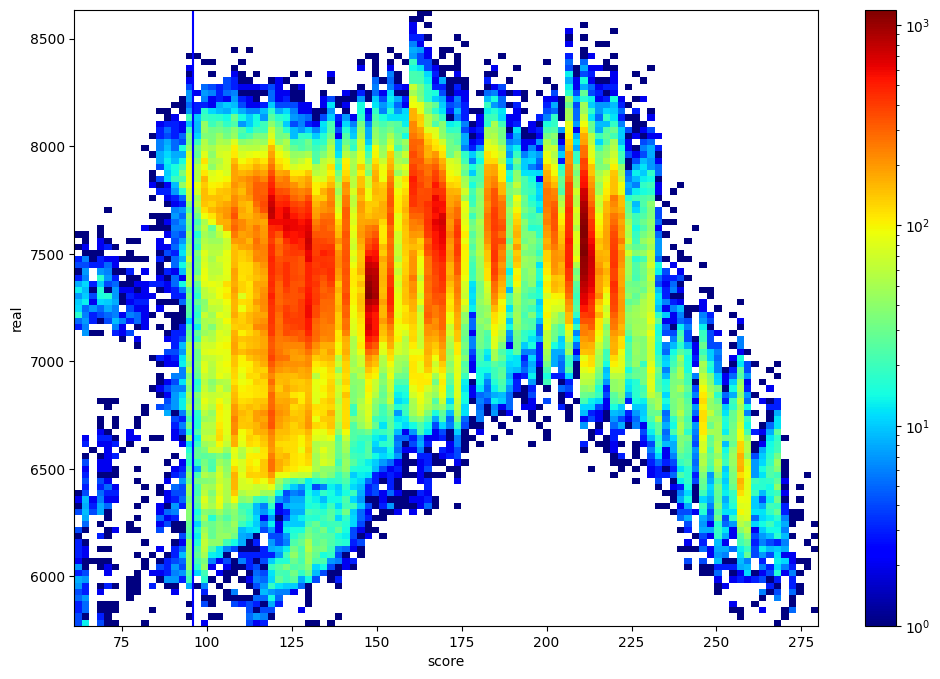

In [39]:
#scores, reals, builds = nirvdata[0:3]
scores, reals, builds = catadata[0:3]

spsum = [i.identifications['rawStrength'].max + i.identifications['rawDexterity'].max for i in builds]

factor = 2.42
x = [(1*i.identifications['rawStrength'].max + 1*i.identifications['rawDexterity'].max) + 0*s for i,s in zip(builds, scores)]
#x = scores
#x = [1*(dmgcalc.spToPct(i.identifications['rawStrength'].max) + dmgcalc.spToPct(i.identifications['rawDexterity'].max)) + s for i,s in zip(builds, snorm)]
threshold = min(x[0:100])
print(factor, threshold, len([i for i in x if i>=threshold]))

r = [[min(x[-200:-100]),max(x)],[reals[-100],reals[0]]]
print(r)

plt.figure(figsize=(12,8))
plot2D(x,reals,r=r,xlabel='str',ylabel='real dmg')
plt.axvline(threshold,color='b')